In [1]:
import os
import sys
from dotenv import load_dotenv
load_dotenv()

import io
import IPython.display
import numpy as np
import cv2
import PIL.Image
import torch

sys.path.append(os.getenv('ROOT') + '/submodules/interfacegan/models')
sys.path.append(os.getenv('ROOT') + '/submodules/interfacegan/utils')

from model_settings import MODEL_POOL
from pggan_generator import PGGANGenerator
from stylegan_generator import StyleGANGenerator
from manipulator import linear_interpolate


/home/vidp/miniconda3/envs/diploma_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def build_generator(model_name):
    """Builds the generator by model name."""
    gan_type = MODEL_POOL[model_name]['gan_type']
    if gan_type == 'pggan':
        generator = PGGANGenerator(model_name)
    elif gan_type == 'stylegan':
        generator = StyleGANGenerator(model_name)
    return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
    """Samples latent codes randomly."""
    np.random.seed(seed)
    codes = generator.easy_sample(num)
    if generator.gan_type == 'stylegan' and latent_space_type == 'W':
        codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
        codes = generator.get_value(generator.model.mapping(codes))
    return codes


def imshow(images, col, viz_size=256):
    """Shows images in one figure."""
    num, height, width, channels = images.shape
    assert num % col == 0
    row = num // col

    fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

    for idx, image in enumerate(images):
        i, j = divmod(idx, col)
        y = i * viz_size
        x = j * viz_size
        if height != viz_size or width != viz_size:
            image = cv2.resize(image, (viz_size, viz_size))
        fused_image[y:y + viz_size, x:x + viz_size] = image

    fused_image = np.asarray(fused_image, dtype=np.uint8)
    data = io.BytesIO()
    PIL.Image.fromarray(fused_image).save(data, 'jpeg')
    im_data = data.getvalue()
    disp = IPython.display.display(IPython.display.Image(im_data))
    return disp

In [3]:
#@title { display-mode: "form", run: "auto" }
submodule_path = os.getenv('ROOT') + '/submodules/interfacegan'
model_name = "stylegan_ffhq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "W" #@param ['Z', 'W']

generator = build_generator(model_name)

ATTRS = ['age', 'gender', 'eyeglasses', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
    boundary_name = f'{model_name}_{attr_name}'
    if generator.gan_type == 'stylegan' and latent_space_type == 'W':
        boundaries[attr_name] = np.load(f'{submodule_path}/boundaries/{boundary_name}_w_boundary.npy')
    else:
        boundaries[attr_name] = np.load(f'{submodule_path}/boundaries/{boundary_name}_boundary.npy')


#@title { display-mode: "form", run: "auto" }

num_samples = 3 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 100 #@param {type:"slider", min:0, max:1000, step:1}



latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    synthesis_kwargs = {'latent_space_type': 'W'}
else:
    synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

[2023-02-25 14:39:25,742][WARNING] No pre-trained model will be loaded!


AssertionError: Torch not compiled with CUDA enabled

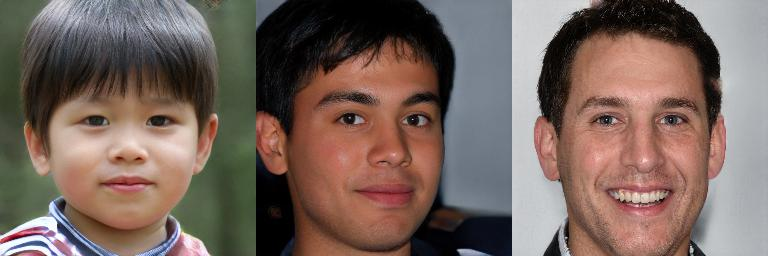

In [4]:
#@title { display-mode: "form", run: "auto" }

age = -1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = -1 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)